In [1]:
import pickle
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager, Layout
from qiskit.transpiler.passes import SetLayout, ApplyLayout, ALAPSchedule, ALAPScheduleAnalysis, BasisTranslator, ASAPSchedule


from models.victim_params import VictimParams


In [2]:
provider = IBMProvider()

# delay(80)-X-delay(160)-X-delay(80)

In [3]:
no_of_qubits = 16
victim_qubits = (5, 8, 11, 14)
snooper_qubits = (3, 9, 13, 2, 12, 1, 10, 15, 0, 4, 6, 7)
ancilla_qubits = ()

In [4]:
with open('./windowed_snooping_experiments/full_1.p', 'rb') as f:
    full_qc_1: QuantumCircuit
    full_one_cnot_qcs: list[QuantumCircuit]
    full_two_cnot_qcs: list[QuantumCircuit]
    (full_qc_1, full_one_cnot_qcs, full_two_cnot_qcs) = pickle.load(f)

In [5]:
full_qcs = [full_qc_1, *full_one_cnot_qcs, *full_two_cnot_qcs]

In [19]:
qregs = full_qcs[0].qregs
qregs

[QuantumRegister(12, 'a'),
 QuantumRegister(4, 'v'),
 QuantumRegister(0, 'ancilla')]

In [20]:
layout_dict = { }

for qreg, index in zip(qregs[0], snooper_qubits):
    layout_dict[qreg] = index

for qreg, index in zip(qregs[1], victim_qubits):
    layout_dict[qreg] = index

for qreg, index in zip(qregs[2], ancilla_qubits):
    layout_dict[qreg] = index

In [21]:
ibm_backend_name = 'ibmq_guadalupe'
backend = provider.get_backend(ibm_backend_name)

In [22]:
pm = generate_preset_pass_manager(0, backend)
layout = Layout(layout_dict)
pm.layout = PassManager([
    SetLayout(layout),
    ApplyLayout()
])

pm.scheduling = PassManager([
    ALAPSchedule(backend.instruction_durations)
])

### timeline diagram

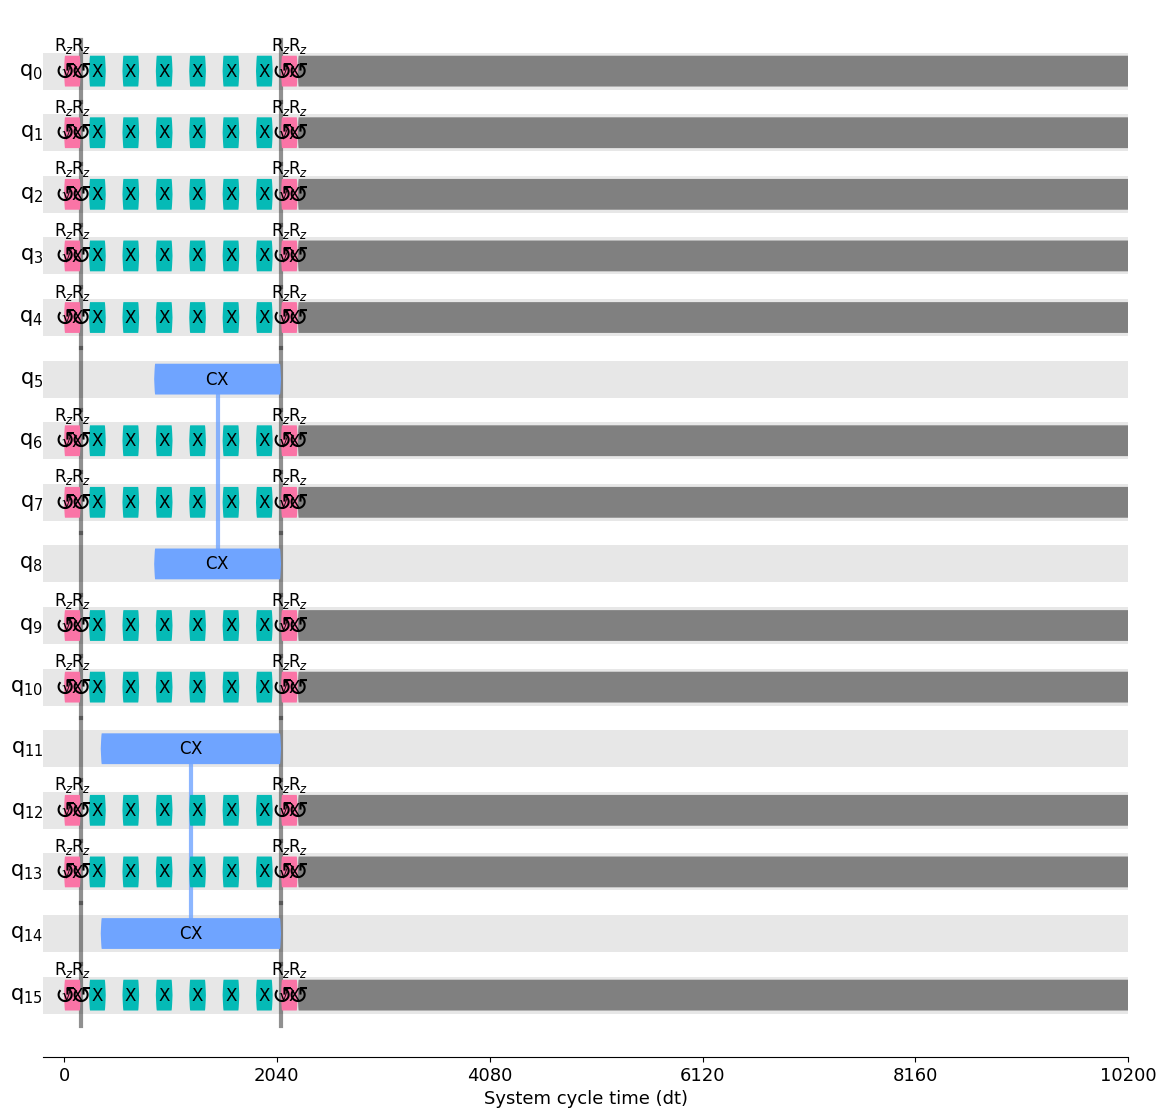

In [24]:
from qiskit.visualization import timeline_drawer

i = 8
tqc = pm.run(full_qcs[i])
# display(tqc.draw('mpl'))
display(timeline_drawer(tqc, time_range=(0, 10000)))

## Run on Guadalupe

In [25]:
tqcs = pm.run(full_qcs)

In [26]:
job = backend.run(tqcs, shots=8000)
job.update_tags(['snooping', '4_chain_5_8_11_14_1920dt_window'])
print('New job: ', job.job_id())

New job:  ci8rqlhg5luj4chgblug
